In [1]:
%use kandy(0.4.5-dev-31)
%use dataframe(0.12.0)
@file:Repository("https://packages.jetbrains.team/maven/p/kds/kotlin-ds-maven")
@file:DependsOn("org.jetbrains.kotlinx:kotlin-statistics-jvm:0.0.0-dev-11")

* [Basics](#Basics)
  * [Data](#Data)
  * [Plot creation](#Plot-creation)
    * [Layers, aesthetics, mappings and scales](#Layers,-aesthetics,-mappings-and-scales)
    * [Scale parameters: axis and legend](#Scale-parameters:-axis-and-legend)
    * [Global X and Y mappings and scales](#Global-X-and-Y-mappings-and-scales)
    * [Raw source mapping](#Raw-source-mapping)
* [Kotlin DataFrame API](#Kotlin-DataFrame-API)
* [Grouping](#Grouping)
  * [Implicit grouping](#Implicit-grouping)
  * [Position](#Position)
* [Experimental](#Experimental)
  * [Multiplot](#Multiplot)
    * [Plot grid](#Plot-grid)
    * [Plot bunch](#Plot-bunch)
    * [Facetting](#Facetting)
  * [Statistics](#Statistics)
  * [Layout](#Layout)
    * [Title, subtitle, caption and size](#Title,-subtitle,-caption-and-size)
    * [Themes](#Themes)
      * [Custom themes](#Custom-themes)
  * [Custom scales](#Custom-scales)
  * [Tooltips](#Tooltips)
  * [Export](#Export)

# Basics

## Data

The main data model for working with plotting is a "named data" or "dataframe", i.e. a set of named value columns of the same size. The input data must have the form `Map<String, List<*>>`.

In [2]:
val simpleDataset = mapOf(
    "time, ms" to listOf(12, 87, 130, 149, 200, 221, 250),
    "relativeHumidity" to listOf(0.45, 0.3, 0.21, 0.15, 0.22, 0.36, 0.8),
    "flowOn" to listOf(true, true, false, false, true, false, false),
)

In the future we will need to refer to the columns of our dataset. To do this, we need to create a pointer for each one.

In [3]:
// 1. Using `column()` function. We need specify type of column and its name in the dataset:
val timeMs = column<Int>("time, ms")
// 2. String API similar to the previous one, but with using invocation of `String`:
val humidity = "relativeHumidity"<Double>()
// 3. Using delegation of unnamed column - its name will be taken from the name of the variable:
val flowOn by column<Boolean>()

## Plot creation

To create a plot, you need to call the `plot()` function by passing a dataset as an argument. This function creates a context in which you can add layers. A *layer* is a set of mappings from the data to the plot visual parameters (so-called *aesthetic attributes*). Here's an example of a graph with one simple layer:

In [4]:
plot(simpleDataset) {
    points {
        // maps values from "time, ms" column to `X`
        x(timeMs)
        // maps values from "relativeHumidity" column to `Y`
        y(humidity)
        // set size of points to 4.5
        size = 4.5
        // map valuues from "flowOn" column to `COLOR`
        color(flowOn)
    }
}

50
 
 
 
 
 
 
 
 
 100
 
 
 
 
 
 
 
 
 150
 
 
 
 
 
 
 
 
 200
 
 
 
 
 
 
 
 
 250
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 0.3
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 0.5
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 0.7
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 relativeHumidity
 
 
 
 
 time, ms
 
 
 
 
 
 
 
 
 flowOn
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 true
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 false

### Layers, aesthetics, mappings and scales

Each layer is characterized by its *geometrical entity* or just *geom*. Each geom has its own set of *aesthetic attributes* or simply *aesthetics* or *aes*. Aesthetics can be *positional* (e.g. `x`, `y`, `yMin`, `yMax`, `middle`) or *non-positional* (such as `color`, `size`, `width`). Non-positional attributes are characterized by some type (for example, `size` associated with `Double`, `color` with a special type `Color`).
The aes value can be assigned in 2 ways: by setting and by mapping.

*Setting* is a simply setting constant value:
```kotlin
// using `.constant()` synytax for positional aes:
x.constant(12.0f)
yMin.constant(10.0)

// using assignment for non-positional aes:
size = 5.0
color = Color.RED
```

*Mapping* is a mapping from the data column to the values of the aesthetic attribute.There are different ways to define it:
```kotlin
// with `ColumnReference`
x(timeMs)
size(humidity)
color(flowOn)

// with raw `String`
x("time, ms")
size("relativeHumidity")

// or we can provide values directly, for example with `Iterabe`
x(listOf(12, 87, 130, 149, 200, 221, 250))
// in this case we can additionally set the id of source:
color(listOf(true, true, false, false, true, false, false), "flow on")
```

The function of this mapping is called *scale*. Scales play a key role in data visualization. In the examples above, the mappings use the default scales, but we can specify the scales explicitly. There are two types of scales  &mdash; *categorical* (or discrete) and *continuous*, depends on its domain and range type. If scale is continuous, its domain and range are set using limits, while categorical scale domain and range are set like lists of categories and corresponding to them values (note that for positional scales, that is, for scales that apply to positional aes, domain and range are the same.). Scales are typed (with domain/range types). Continuous scales have `transform` parameter; it defines the function transformation (which is linear by default).

Scale can be applied after mapping using the following syntax:

In [5]:
plot(simpleDataset) {
    points {
        x(listOf(12, 87, 130, 149, 200, 221, 250)) {
            scale = continuous(min = 0, max = 270) // using `min`/`max`
        }
        y(humidity) {
            scale = continuous(0.0..1.0) // using `Range`
        }
        size(humidity) {
            scale = continuous<Double, Double>(range = 5.0..20.0,) // dont's should specify
        }
        color(flowOn) {
            scale = categorical(true to Color.RED, false to Color.BLUE)
        }
        symbol(flowOn) {
            scale = categorical()// default scale
        }
        alpha = 0.9
    }
}

0
 
 
 
 
 
 
 
 
 50
 
 
 
 
 
 
 
 
 100
 
 
 
 
 
 
 
 
 150
 
 
 
 
 
 
 
 
 200
 
 
 
 
 
 
 
 
 250
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.0
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 1.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 relativeHumidity
 
 
 
 
 x
 
 
 
 
 
 
 
 
 relativeHumidity
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.3
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.5
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 
 
 
 
 
 
 flowOn
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 true
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 false

We can also separately create scales out of context and then apply them:

In [6]:
val xReversedScale = Scale.continuousPos<Int>(transform = Transformation.REVERSE)
val yScale = Scale.continuousPos(0.0..0.9)
val colorScale = Scale.categorical<Color, Boolean>(range = listOf(
    Color.RED, Color.GREEN
))

In [7]:
plot(simpleDataset) {
    points {
        x(listOf(12, 87, 130, 149, 200, 221, 250)) {
            scale = xReversedScale
        }
        y(humidity) {
            scale = yScale
        }
        color(flowOn) {
            scale = colorScale
        }
        symbol = Symbol.ASTERIX
        size = 6.6
    }
}

50
 
 
 
 
 
 
 
 
 100
 
 
 
 
 
 
 
 
 150
 
 
 
 
 
 
 
 
 200
 
 
 
 
 
 
 
 
 250
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.0
 
 
 
 
 
 
 0.1
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 0.3
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 0.5
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 0.7
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 0.9
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 relativeHumidity
 
 
 
 
 x
 
 
 
 
 
 
 
 
 flowOn
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 true
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 false

### Scale parameters: axis and legend

The most important part of reading the charts is the *guides*. They are in fact essentially mini-charts of scales. The guides of positional scales are *axes*, and the guides of non-positional ones are *legends*. Every applied scale has its own default guide. You can customize it through use `with`

In [8]:
plot(simpleDataset) {
    points {
        x(timeMs) {
            axis.name = "Time from start of counting,\n milliseconds"
        }
        y(humidity) {
            scale = continuous(0.0 .. 1.0)
            axis {
                name = "Relative humidity"
                breaksLabeled(0.0 to "0%", 0.3 to "30%", 0.6 to "60%", 0.9 to "90%")
            }
         }
        size = 12.0
        color(humidity) {
            scale = continuous()
            legend {
                name = "rel. humidity"
                type = LegendType.ColorBar(40.0, 190.0, 15)
                breaks(format = "e")
            }
        }
    }
}

50
 
 
 
 
 
 
 
 
 100
 
 
 
 
 
 
 
 
 150
 
 
 
 
 
 
 
 
 200
 
 
 
 
 
 
 
 
 250
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0%
 
 
 
 
 
 
 30%
 
 
 
 
 
 
 60%
 
 
 
 
 
 
 90%
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Relative humidity
 
 
 
 
 Time from start of counting,
 
 
 milliseconds
 
 
 
 
 
 
 
 
 rel. humidity
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2.000000e-1
 
 
 
 
 
 
 
 
 3.000000e-1
 
 
 
 
 
 
 
 
 4.000000e-1
 
 
 
 
 
 
 
 
 5.000000e-1
 
 
 
 
 
 
 
 
 6.000000e-1
 
 
 
 
 
 
 
 
 7.000000e-1
 
 
 
 
 
 
 
 
 8.000000e-1

### Global X and Y mappings and scales

If you want to use `X` or `Y` mapping in multiple layers you can use global mapping in the main plot context. The layers will inherit this mapping (in case they have these aesthetics). They can also be overridden inside a layer context.

In [9]:
plot(simpleDataset) {
    x(timeMs) {
        scale = continuous(max = 275)
    }
    y(humidity)
    points {
        // `x` and `y` are taken from a parental context
        size = 4.5
        color(flowOn)
    }
    line {
        // `x` is taken from a parental context, but `y` is overriden
        y(listOf(0.49, 0.39, 0.1, 0.4, 0.8, 0.8, 0.9))
        width = 3.0
        color = Color.RED
    }
}

0
 
 
 
 
 
 
 
 
 50
 
 
 
 
 
 
 
 
 100
 
 
 
 
 
 
 
 
 150
 
 
 
 
 
 
 
 
 200
 
 
 
 
 
 
 
 
 250
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.1
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 0.3
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 0.5
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 0.7
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 0.9
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 y
 
 
 
 
 time, ms
 
 
 
 
 
 
 
 
 flowOn
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 true
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 false

Scales along axes can be configured without mapping inside the raft context:

In [10]:
plot(simpleDataset) {
    points {
        x(listOf(10, 20, 30, 40, 50, 60, 70))
        y(humidity)
        size = 4.5
        color(flowOn)
    }
    x.axis.name = "time, ms"
    y {
        scale = continuous(min = 0.0)
        axis.breaks(format = ".2f")
    }
}

10
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 50
 
 
 
 
 
 
 
 
 60
 
 
 
 
 
 
 
 
 70
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.00
 
 
 
 
 
 
 0.10
 
 
 
 
 
 
 0.20
 
 
 
 
 
 
 0.30
 
 
 
 
 
 
 0.40
 
 
 
 
 
 
 0.50
 
 
 
 
 
 
 0.60
 
 
 
 
 
 
 0.70
 
 
 
 
 
 
 0.80
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 relativeHumidity
 
 
 
 
 time, ms
 
 
 
 
 
 
 
 
 flowOn
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 true
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 false

In [11]:
plot(simpleDataset) {
    points {
        x(listOf(10, 20, 30, 40, 50, 60, 70))
        y(humidity)
        size = 4.5
        color(flowOn)
    }
    // Alternate brief notation if we want to set the axis limits (continuous scale)
    x.limits = 0 .. 80
    y.limits = 0.0..1.0
}

0
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 60
 
 
 
 
 
 
 
 
 80
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.0
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 1.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 relativeHumidity
 
 
 
 
 x
 
 
 
 
 
 
 
 
 flowOn
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 true
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 false

This mechanism is called "free scale". It is especially useful in the case of "sub-positional" aesthetics. These aesthetics are similar to positional aesthetics, but they do not have their own scales --- the scales of the parent positional aesthetic are applied to them. However, often in this case, the parent aes itself is not mapped, and free scale allows us to set limits and other settings for the corresponding axis. For example `boxplot` layer has five sub-positional aes: `yMin`, `yMax`, `middle`, `lower`, `upper`.
Also some aesthetics cannot be mapped, only be set (for example: `fatten` in boxplot and some other layers).

In [12]:
plot(
    mapOf(
        "x" to listOf("a", "b", "c"),
        "min" to listOf(0.8, 0.4, 0.6),
        "lower" to listOf(0.9, 1.4, 0.8),
        "middle" to listOf(1.5, 2.4, 1.6),
        "upper" to listOf(1.9, 3.4, 1.7),
        "max" to listOf(3.1, 4.4, 2.6),
        "width" to listOf(0.1, 1.4, 14.0)
    )
)
    boxplots {
        x("x"<String>())
        // sub-y aesthetics:
        yMin("min"<Double>())
        lower("lower"<Double>())
        middle("middle"<Double>())
        upper("upper"<Double>())
        yMax("max"<Double>())
        fatten = 4.5
        alpha = 0.2
        borderLine.color = Color.hex(0x9A2A2A)
    }
    y {
        axis.name = "weigth"
        limits = 0.0 .. 5.0
    }
}

Line_21.jupyter.kts (28:1 - 2) Unexpected symbol

### Raw source mapping

As mentioned before, in addition to mapping with a dataset column pointer, you can use mapping directly from a data source (currently only `Iterable` is supported). Also, you can name the source you use (to display it in the guide, for example)
Of course, all the sources used for mapping as well as the initial dataset columns must have the same size.

In [13]:
val month = listOf("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
val numberOfDays = listOf(31, 28, 31, 30, 31, 30, 31, 30, 31, 30, 31, 30)
val season = listOf("winter", "winter", "spring", "spring", "spring", "summer", "summer", "summer", "autumn", "autumn", "autumn", "winter")

In [14]:
plot {
    bars {
        x(month, "month") {
            scale = categorical()
        }
        y(numberOfDays, "number of days")
        fillColor(season, "season") {
            scale = categorical(
                listOf(Color.BLUE, Color.GREEN, Color.RED, Color.ORANGE),
                listOf("winter", "spring", "summer", "autumn"),
            )
        }
    }
}

January
 
 
 
 
 
 
 
 
 February
 
 
 
 
 
 
 
 
 March
 
 
 
 
 
 
 
 
 April
 
 
 
 
 
 
 
 
 May
 
 
 
 
 
 
 
 
 June
 
 
 
 
 
 
 
 
 July
 
 
 
 
 
 
 
 
 August
 
 
 
 
 
 
 
 
 September
 
 
 
 
 
 
 
 
 October
 
 
 
 
 
 
 
 
 November
 
 
 
 
 
 
 
 
 December
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 5
 
 
 
 
 
 
 10
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 number of days
 
 
 
 
 month
 
 
 
 
 
 
 
 
 season
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 winter
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 spring
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 summer
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 autumn

# Kotlin DataFrame API

Integration with the [Kotlin DataFrame](https://github.com/Kotlin/dataframe) library allows you to use `DataFrame` as a data source and `DataColumn` as a mapping source. With the auto-generation of property columns, you don't need to create column pointers manually.

In [15]:
val mpgDF = DataFrame.readCSV("https://raw.githubusercontent.com/JetBrains/lets-plot-kotlin/master/docs/examples/data/mpg.csv")
mpgDF.head()

<iframe onload="o_resize_iframe_out_1()" style="width:100%;" class="result_container" id="iframe_out_1" frameBorder="0" srcdoc=" <html>
 <head>
 <style type="text/css">
 :root {
 --background: #fff;
 --background-odd: #f5f5f5;
 --background-hover: #d9edfd;
 --header-text-color: #474747;
 --text-color: #848484;
 --text-color-dark: #000;
 --text-color-medium: #737373;
 --text-color-pale: #b3b3b3;
 --inner-border-color: #aaa;
 --bold-border-color: #000;
 --link-color: #296eaa;
 --link-color-pale: #296eaa;
 --link-hover: #1a466c;
}

:root[theme="dark"], :root [data-jp-theme-light="false"], .dataframe_dark{
 --background: #303030;
 --background-odd: #3c3c3c;
 --background-hover: #464646;
 --header-text-color: #dddddd;
 --text-color: #b3b3b3;
 --text-color-dark: #dddddd;
 --text-color-medium: #b2b2b2;
 --text-color-pale: #737373;
 --inner-border-color: #707070;
 --bold-border-color: #777777;
 --link-color: #008dc0;
 --link-color-pale: #97e1fb;
 --link-hover: #00688e;
}

p.dataframe_description {
 color: var(--text-color-dark);
}

table.dataframe {
 font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
 font-size: 12px;
 background-color: var(--background);
 color: var(--text-color-dark);
 border: none;
 border-collapse: collapse;
}

table.dataframe th, td {
 padding: 6px;
 border: 1px solid transparent;
 text-align: left;
}

table.dataframe th {
 background-color: var(--background);
 color: var(--header-text-color);
}

table.dataframe td {
 vertical-align: top;
}

table.dataframe th.bottomBorder {
 border-bottom-color: var(--bold-border-color);
}

table.dataframe tbody > tr:nth-child(odd) {
 background: var(--background-odd);
}

table.dataframe tbody > tr:nth-child(even) {
 background: var(--background);
}

table.dataframe tbody > tr:hover {
 background: var(--background-hover);
}

table.dataframe a {
 cursor: pointer;
 color: var(--link-color);
 text-decoration: none;
}

table.dataframe tr:hover > td a {
 color: var(--link-color-pale);
}

table.dataframe a:hover {
 color: var(--link-hover);
 text-decoration: underline;
}

table.dataframe img {
 max-width: fit-content;
}

table.dataframe th.complex {
 background-color: var(--background);
 border: 1px solid var(--background);
}

table.dataframe .leftBorder {
 border-left-color: var(--inner-border-color);
}

table.dataframe .rightBorder {
 border-right-color: var(--inner-border-color);
}

table.dataframe .rightAlign {
 text-align: right;
}

table.dataframe .expanderSvg {
 width: 8px;
 height: 8px;
 margin-right: 3px;
}

table.dataframe .expander {
 display: flex;
 align-items: center;
}

/* formatting */

table.dataframe .null {
 color: var(--text-color-pale);
}

table.dataframe .structural {
 color: var(--text-color-medium);
 font-weight: bold;
}

table.dataframe .dataFrameCaption {
 font-weight: bold;
}

table.dataframe .numbers {
 color: var(--text-color-dark);
}

table.dataframe td:hover .formatted .structural, .null {
 color: var(--text-color-dark);
}

table.dataframe tr:hover .formatted .structural, .null {
 color: var(--text-color-dark);
}




:root {
 --scroll-bg: #f5f5f5;
 --scroll-fg: #b3b3b3;
}
:root[theme="dark"], :root [data-jp-theme-light="false"]{
 --scroll-bg: #3c3c3c;
 --scroll-fg: #97e1fb;
}
body {
 scrollbar-color: var(--scroll-fg) var(--scroll-bg);
}
body::-webkit-scrollbar {
 width: 10px; /* Mostly for vertical scrollbars */
 height: 10px; /* Mostly for horizontal scrollbars */
}
body::-webkit-scrollbar-thumb {
 background-color: var(--scroll-fg);
}
body::-webkit-scrollbar-track {
 background-color: var(--scroll-bg);
}
 </style>
 </head>
 <body>
 
<table class="dataframe" id="df_-872415232"></table>

<p class="dataframe_description">DataFrame: rowsCount = 5, columnsCount = 12</p>

 </body>
 <script>
 (function () {
 window.DataFrame = window.DataFrame || new (function () {
 this.addTable = function (df) {
 let cols = df.cols;
 for (let i = 0; i < cols.length; i++) {
 for (let c of cols[i].children) {
 cols[c].parent = i;
 }
 }
 df.nrow = 0
 for (let i = 0; 

In [16]:
mpgDF.schema()

untitled: Int
manufacturer: String
model: String
displ: Double
year: Int
cyl: Int
trans: String
drv: String
cty: Int
hwy: Int
fl: String
class: String

In [17]:
val mpgInfoPlot = mpgDF.plot {
    points {
        x(displ) // auto-generated df columns
        y(cty) {
            scale = continuous(8..34)
        }
        symbol = Symbol.CIRCLE_FILLED
        color = Color.WHITE
        fillColor(drv)
        size(hwy) {
            scale = continuous(5.0..15.0)
        }
    }
}
mpgInfoPlot

2
 
 
 
 
 
 
 
 
 3
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 5
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 cty
 
 
 
 
 displ
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

Of course, if you don't have an autogenerated property-column, you can create a pointer to it manually:

In [18]:
val mpgCountPlot = mpgDF.groupBy { drv }.aggregate {
    count() into "count"
}.plot {
    bars {
        x(drv)
        y("count"<Int>())
        alpha = 0.75
    }
}
mpgCountPlot

f
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 r
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 20
 
 
 
 
 
 
 40
 
 
 
 
 
 
 60
 
 
 
 
 
 
 80
 
 
 
 
 
 
 100
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 count
 
 
 
 
 drv

# Grouping

This part of API allows you to work with grouped data. It's useful for plotting collective geoms (that is, those that contain multiple data units with one geometric object, for example `line`). You can either provide groped dataframe (`GroupBy`) as dataset or perform grouping inside the plot DSL:

In [19]:
val lineDatset = mapOf(
    "timeG" to listOf(1.0, 2.2, 3.4, 6.6, 2.1, 4.4, 6.0, 1.5, 4.7, 6.7),
    "value" to listOf(112.0, 147.3, 111.1, 200.6, 90.8, 110.2, 130.4, 100.1, 90.0, 121.8),
    "c-type" to listOf("A", "A", "A", "A", "B", "B", "B", "C", "C", "C")
)

In [20]:
plot(lineDatset) {
    groupBy("c-type") {
        line {
            x("timeG")
            y("value")
        }
    }
}

1
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 3
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 5
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 100
 
 
 
 
 
 
 120
 
 
 
 
 
 
 140
 
 
 
 
 
 
 160
 
 
 
 
 
 
 180
 
 
 
 
 
 
 200
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 value
 
 
 
 
 timeG

In [21]:
val lineDF = lineDatset.toDataFrame()

In [22]:
lineDF.groupBy {
   `c-type`
}.plot {
    line {
        x(timeG)
        y(value)
    }
}

1
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 3
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 5
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 100
 
 
 
 
 
 
 120
 
 
 
 
 
 
 140
 
 
 
 
 
 
 160
 
 
 
 
 
 
 180
 
 
 
 
 
 
 200
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 value
 
 
 
 
 timeG

In [23]:
lineDF.plot {
    groupBy(`c-type`) {
        line {
            x(timeG)
            y(value)
            color(key.`c-type`)
            width = 4.0
        }
    }
}

1
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 3
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 5
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 100
 
 
 
 
 
 
 120
 
 
 
 
 
 
 140
 
 
 
 
 
 
 160
 
 
 
 
 
 
 180
 
 
 
 
 
 
 200
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 value
 
 
 
 
 timeG
 
 
 
 
 
 
 
 
 c-type
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 A
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 B
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 C

## Implicit grouping

In addition to explicit grouping, grouping can be specified implicitly by using a categorical scale:

In [24]:
lineDF.plot {
    line {
        x(timeG)
        y(value)
        color(`c-type`)
        width = 4.0
    }
}

1
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 3
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 5
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 100
 
 
 
 
 
 
 120
 
 
 
 
 
 
 140
 
 
 
 
 
 
 160
 
 
 
 
 
 
 180
 
 
 
 
 
 
 200
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 value
 
 
 
 
 timeG
 
 
 
 
 
 
 
 
 c-type
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 A
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 B
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 C

## Position

`position` parameter adjusts the relative position of objects from different groups within the same layer.

In [25]:
val meanCylDf = mpgDF.groupBy {cyl and drv}.mean { cty }
meanCylDf.head(5)

<iframe onload="o_resize_iframe_out_2()" style="width:100%;" class="result_container" id="iframe_out_2" frameBorder="0" srcdoc=" <html>
 <head>
 <style type="text/css">
 :root {
 --background: #fff;
 --background-odd: #f5f5f5;
 --background-hover: #d9edfd;
 --header-text-color: #474747;
 --text-color: #848484;
 --text-color-dark: #000;
 --text-color-medium: #737373;
 --text-color-pale: #b3b3b3;
 --inner-border-color: #aaa;
 --bold-border-color: #000;
 --link-color: #296eaa;
 --link-color-pale: #296eaa;
 --link-hover: #1a466c;
}

:root[theme="dark"], :root [data-jp-theme-light="false"], .dataframe_dark{
 --background: #303030;
 --background-odd: #3c3c3c;
 --background-hover: #464646;
 --header-text-color: #dddddd;
 --text-color: #b3b3b3;
 --text-color-dark: #dddddd;
 --text-color-medium: #b2b2b2;
 --text-color-pale: #737373;
 --inner-border-color: #707070;
 --bold-border-color: #777777;
 --link-color: #008dc0;
 --link-color-pale: #97e1fb;
 --link-hover: #00688e;
}

p.dataframe_description {
 color: var(--text-color-dark);
}

table.dataframe {
 font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
 font-size: 12px;
 background-color: var(--background);
 color: var(--text-color-dark);
 border: none;
 border-collapse: collapse;
}

table.dataframe th, td {
 padding: 6px;
 border: 1px solid transparent;
 text-align: left;
}

table.dataframe th {
 background-color: var(--background);
 color: var(--header-text-color);
}

table.dataframe td {
 vertical-align: top;
}

table.dataframe th.bottomBorder {
 border-bottom-color: var(--bold-border-color);
}

table.dataframe tbody > tr:nth-child(odd) {
 background: var(--background-odd);
}

table.dataframe tbody > tr:nth-child(even) {
 background: var(--background);
}

table.dataframe tbody > tr:hover {
 background: var(--background-hover);
}

table.dataframe a {
 cursor: pointer;
 color: var(--link-color);
 text-decoration: none;
}

table.dataframe tr:hover > td a {
 color: var(--link-color-pale);
}

table.dataframe a:hover {
 color: var(--link-hover);
 text-decoration: underline;
}

table.dataframe img {
 max-width: fit-content;
}

table.dataframe th.complex {
 background-color: var(--background);
 border: 1px solid var(--background);
}

table.dataframe .leftBorder {
 border-left-color: var(--inner-border-color);
}

table.dataframe .rightBorder {
 border-right-color: var(--inner-border-color);
}

table.dataframe .rightAlign {
 text-align: right;
}

table.dataframe .expanderSvg {
 width: 8px;
 height: 8px;
 margin-right: 3px;
}

table.dataframe .expander {
 display: flex;
 align-items: center;
}

/* formatting */

table.dataframe .null {
 color: var(--text-color-pale);
}

table.dataframe .structural {
 color: var(--text-color-medium);
 font-weight: bold;
}

table.dataframe .dataFrameCaption {
 font-weight: bold;
}

table.dataframe .numbers {
 color: var(--text-color-dark);
}

table.dataframe td:hover .formatted .structural, .null {
 color: var(--text-color-dark);
}

table.dataframe tr:hover .formatted .structural, .null {
 color: var(--text-color-dark);
}




:root {
 --scroll-bg: #f5f5f5;
 --scroll-fg: #b3b3b3;
}
:root[theme="dark"], :root [data-jp-theme-light="false"]{
 --scroll-bg: #3c3c3c;
 --scroll-fg: #97e1fb;
}
body {
 scrollbar-color: var(--scroll-fg) var(--scroll-bg);
}
body::-webkit-scrollbar {
 width: 10px; /* Mostly for vertical scrollbars */
 height: 10px; /* Mostly for horizontal scrollbars */
}
body::-webkit-scrollbar-thumb {
 background-color: var(--scroll-fg);
}
body::-webkit-scrollbar-track {
 background-color: var(--scroll-bg);
}
 </style>
 </head>
 <body>
 
<table class="dataframe" id="df_-872415231"></table>

<p class="dataframe_description">DataFrame: rowsCount = 5, columnsCount = 3</p>

 </body>
 <script>
 (function () {
 window.DataFrame = window.DataFrame || new (function () {
 this.addTable = function (df) {
 let cols = df.cols;
 for (let i = 0; i < cols.length; i++) {
 for (let c of cols[i].children) {
 cols[c].parent = i;
 }
 }
 df.nrow = 0
 for (let i = 0; i

In [26]:
val meanCylPlot = meanCylDf.groupBy {cyl}.plot {
   bars {
       x(drv)
       y(cty.rename("mean_cty"))
       fillColor(cyl)

       // by fedault for `bars` layer
       position = Position.dodge()
   }
}
meanCylPlot

f
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 r
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 5
 
 
 
 
 
 
 10
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 mean_cty
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 cyl
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 6.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 8.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5.0

In [27]:
meanCylDf.groupBy {cyl}.plot {
   bars {
       x(drv)
       y(cty.rename("mean_cty"))
       fillColor(cyl)
       alpha = 0.4

       position = Position.identity()
   }
}

f
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 r
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 5
 
 
 
 
 
 
 10
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 mean_cty
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 cyl
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 6.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 8.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5.0

In [28]:
meanCylDf.groupBy {cyl}.plot {
   bars {
       x(drv)
       y(cty.rename("mean_cty"))
       fillColor(cyl)

       position = Position.stack()
   }
}

f
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 r
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 10
 
 
 
 
 
 
 20
 
 
 
 
 
 
 30
 
 
 
 
 
 
 40
 
 
 
 
 
 
 50
 
 
 
 
 
 
 60
 
 
 
 
 
 
 70
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 mean_cty
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 cyl
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 6.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 8.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5.0

*Note*: `position` works only between groups in one layer, so it is impossible to configure the relative position of objects from different layers.

# Experimental

The following API is experimental and may be significantly changed in the future.

## Multiplot

There are 3 ways to create a multiplot: `plotGrid`, `plotBunch` and facetting.

### Plot grid

`plotGrid` function arrange plots in cells of a regular grid.

In [29]:
plotGrid(listOf(mpgInfoPlot, mpgCountPlot, meanCylPlot), 2)

2
 
 
 
 
 
 
 
 
 3
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 5
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 cty
 
 
 
 
 displ
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 r
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 20
 
 
 
 
 
 
 40
 
 
 
 
 
 
 60
 
 
 
 
 
 
 80
 
 
 
 
 
 
 100
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 count
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 r
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 5
 
 
 
 
 
 
 10
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 mean_cty
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 cyl
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 6.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 8.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5.0

### Plot bunch

Collection of plots without an automatic layout. Each plot can have arbitrary location and size.

In [30]:
// TODO fix bunch rendering in swing
plotBunch {
    add(mpgCountPlot, 0, 0, 400, 200)
    add(meanCylPlot, 400, 0, 300, 200)
    add(mpgInfoPlot, 0, 200, 700, 300)
}

f
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 r
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 50
 
 
 
 
 
 
 100
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 count
 
 
 
 
 drv
 
 
 
 
 
 
 

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 r
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 10
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 mean_cty
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 cyl
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 6.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 8.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5.0
 
 
 
 
 
 
 
 
 
 
 

 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 3
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 5
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 cty
 
 
 
 
 displ
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

### Facetting

Facetting creates a multiplot from one plot by splitting dataset (like `groupBy`). Facetting can be applied by invocation `facetGridX`, `facetGridY` (for creating facetting by 1 parameter along `X` and `Y` axes correspondingly), `facetGrid`(for creating facetting by 2 parameter along `X` and `Y` axes) and `facetWrap` (for creating facetting by multiple parameteres).

In [31]:
mpgDF.plot {
    points {
        x(displ)
        y(cty) {
            scale = continuous(8..34)
        }

        symbol = Symbol.CIRCLE_FILLED
        color = Color.WHITE
        fillColor(drv)
        size(hwy) {
            scale = continuous(2.0..10.0)
        }
    }

    layout.size = 750 to 450

    facetGridX(drv, scalesSharing = ScalesSharing.FREE_X)
}

4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 cty
 
 
 
 
 displ
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

In [32]:
mpgDF.plot {
    points {
        x(displ)
        y(cty) {
            scale = continuous(8..34)
        }

        symbol = Symbol.CIRCLE_FILLED
        color = Color.WHITE
        fillColor(drv)
        size(hwy) {
            scale = continuous(2.0..10.0)
        }
    }

    layout.size = 750 to 450

    facetGridY(cyl)
}

4.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 6.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 8.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 3
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 5
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 7
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 cty
 
 
 
 
 displ
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

In [33]:
mpgDF.plot {
    points {
        x(displ)
        y(cty) {
            scale = continuous(8..34)
        }

        symbol = Symbol.CIRCLE_FILLED
        color = Color.WHITE
        fillColor(drv)
        size(hwy) {
            scale = continuous(2.0..10.0)
        }
    }

    layout.size = 750 to 450

    facetGrid(drv, cyl)
}

4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r
 
 
 
 
 4.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 6.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 8.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 cty
 
 
 
 
 displ
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

In [34]:
mpgDF.plot {
    points {
        x(displ)
        y(cty) {
            scale = continuous(8..34)
        }

        symbol = Symbol.CIRCLE_FILLED
        color = Color.WHITE
        fillColor(drv)
        size(hwy) {
            scale = continuous(2.0..10.0)
        }
    }

    layout.size = 750 to 450

    facetWrap(nCol = 3, scalesSharing = ScalesSharing.FREE) {
        facet(drv)
        facet(cyl, order = OrderDirection.DESCENDING)
    }
}

4
 
 
 
 
 8.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 5
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 6.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3.0
 
 
 
 
 
 
 
 
 3.5
 
 
 
 
 
 
 
 
 4.0
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 5.0
 
 
 
 
 
 
 
 
 
 
 -0.5
 
 
 
 
 
 
 
 
 0.0
 
 
 
 
 
 
 
 
 0.5
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 4.0
 
 
 
 
 
 
 
 
 
 
 
 
 2.0
 
 
 
 
 
 
 
 
 2.5
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 8.0
 
 
 
 
 
 
 
 
 
 
 
 
 5.0
 
 
 
 
 
 
 
 
 5.5
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 6.0
 
 
 
 
 
 
 
 
 
 
 
 
 3
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 5.0
 
 
 
 
 
 
 
 
 
 
 2.0
 
 
 
 
 
 
 
 
 2.5
 
 
 
 
 
 
 
 
 3.0
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 4.0
 
 
 
 
 
 
 
 
 
 
 
 
 2.0
 
 
 
 
 
 
 
 
 2.5
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r
 
 
 
 
 8.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 5
 
 
 
 
 
 
 
 
 6
 
 
 
 
 
 
 
 
 7
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r
 
 
 
 
 6.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3.8
 
 
 
 
 
 
 
 
 3.9
 
 
 
 
 
 
 
 
 4.0
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r
 
 
 
 
 5.0
 
 
 
 
 
 
 
 
 
 
 -0.5
 
 
 
 
 
 
 
 
 0.0
 
 
 
 
 
 
 
 
 0.5
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r
 
 
 
 
 4.0
 
 
 
 
 
 
 
 
 
 
 -0.5
 
 
 
 
 
 
 
 
 0.0
 
 
 
 
 
 
 
 
 0.5
 
 
 
 
 
 
 
 
 
 
 6.7
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 cty
 
 
 
 
 displ
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

## Statistics

Rather than using statistical pre-transformations of your dataset, you can calculate it inside the DSL. The "stat" family of functions is used for this purpose. These functions convert the original data into a new dataset with calculated statistics. The set of these statistics is defined by the function. Within a context, its statistics can be accessed through the `Stat` field.These statistics act as pointers to the columns in the new dataset. And you can do the same thing with them as with regular `ColumnReference` : they can be mapped to aesthetics, scaled, used in tooltips, etc.

In [35]:
import kotlin.random.Random

val observations = List(1000) { Random.nextDouble() }
val observationsDataset = mapOf(
    "observations" to observations
)
val obs = column<Double>("observations")

In [36]:
plot(observationsDataset) {
    statBin(obs) {
         bars {
            // simple mapping
            x(Stat.x)
            // mapping with scale
            y(Stat.count) {
                scale = continuous(0..100, transform = Transformation.REVERSE)
            }

            alpha = 0.5

            // formatting of stat value format
            tooltips {
                // line with the name of stat (i.e. "count") on the left side and its value on the right side
                line(Stat.count, format = "d")
             }
         }

         line {
             x(Stat.x)
             y(Stat.count)

             width = 2.5
             color = Color.RED
         }
    }
}

0.0
 
 
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 
 
 1.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 10
 
 
 
 
 
 
 20
 
 
 
 
 
 
 30
 
 
 
 
 
 
 40
 
 
 
 
 
 
 50
 
 
 
 
 
 
 60
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path d="M35.979033816066526 287.2967032967033 L35.979033816066526 287.2967032967033 L60.87801915590497 267.13553113553115 L85.77700449574341 287.2967032967033 L110.67598983558184 206.65201465201466 L135.5749751754203 236.89377289377288 L160.47396051525874 201.6117216117216 L185.37294585509719 246.97435897435898 L210.27193119493563 262.0952380952381 L235.17091653477405 287.2967032967033 L260.0699018746125 186.49084249084248 L284.96888721445094 236.89377289377288 L309.8678725542895 246.97435897435898 L334.76685789412784 246.97435897435898 L359.66584323396637 211.69230769230768 L384.56482857380473 226.8131868131868 L409.4638139136432 327.6190476190476 L434.3627992534816 287.2967032967033 L459.2617845933201 322.57875457875457 L484.16076993315846 191.53113553113553 L509.059755272997 272.1758241758242 " fill="none" stroke-width="5.5" stroke="rgb(238,102,102)" stroke-opacity="1.0">
 
 
 
 
 
 
 count
 
 
 
 
 x

In addition, for basic statistical charts there is a simpler API, which combines into one function the counting of statistics and the creation of a layer. For example, a histogram is nothing more than a counting of "bin" statistics and a bar chart that has bins values on X and count values on Y.

In [37]:
val histPlot = plot(observationsDataset) {
    histogram(obs)

    layout.title = "`histogram`"
}
histPlot

0.0
 
 
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 
 
 1.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 10
 
 
 
 
 
 
 20
 
 
 
 
 
 
 30
 
 
 
 
 
 
 40
 
 
 
 
 
 
 50
 
 
 
 
 
 
 60
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 `histogram`
 
 
 
 
 count
 
 
 
 
 observations

You can compare it to a bar chart with the calculation of bins stat:

In [38]:
val binBarPlot = plot(observationsDataset) {
    statBin(obs) {
        bars {
            x(Stat.x)
            y(Stat.count)
         }
    }
    layout.title = "`statBin` + `bar`"
}

plotGrid(listOf(histPlot, binBarPlot), 2)

0.0
 
 
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 
 
 1.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 10
 
 
 
 
 
 
 20
 
 
 
 
 
 
 30
 
 
 
 
 
 
 40
 
 
 
 
 
 
 50
 
 
 
 
 
 
 60
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 `histogram`
 
 
 
 
 count
 
 
 
 
 observations
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.0
 
 
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 
 
 1.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 10
 
 
 
 
 
 
 20
 
 
 
 
 
 
 30
 
 
 
 
 
 
 40
 
 
 
 
 
 
 50
 
 
 
 
 
 
 60
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 `statBin` + `bar`
 
 
 
 
 count
 
 
 
 
 x

`histogram` function also opens a context, in which you can create bindings for the aesthetic attributes of the bar. In addition, the "stat-bin" stats are defined in this context, allowing you to map them to aesthetics. Also, you can rewrite default mappings to coordinates (to display relative values instead of absolute ones, for example).

In [39]:
plot(observationsDataset) {
    histogram(obs, binsOption =  BinsOption.byWidth(0.05), binsAlign = BinsAlign.center(0.5)) {
        y(Stat.density)

        fillColor(Stat.count) {
            scale= continuous(Color.GREEN .. Color.RED)
        }

        borderLine {
            color=Color.BLACK
            width=0.3
        }

        tooltips(title = "${value(Stat.x)} ± 0.025") {
            line(Stat.density)
        }
    }
}

0.0
 
 
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 
 
 1.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.0
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 1.0
 
 
 
 
 
 
 1.2
 
 
 
 
 
 
 1.4
 
 
 
 
 
 
 1.6
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 density
 
 
 
 
 observations
 
 
 
 
 
 
 
 
 count
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 50
 
 
 
 
 
 
 
 
 60
 
 
 
 
 
 
 
 
 70
 
 
 
 
 
 
 
 
 80

Stats API works with `Iterable` as well:

In [40]:
plotGrid(listOf(
    plot {
        statBin(observations) {
            points {
                x(Stat.density)
                y(Stat.x)
            }
        }
    },
    plot {
        histogram(observations)
    }
), 2)

0.8
 
 
 
 
 
 
 
 
 0.9
 
 
 
 
 
 
 
 
 1.0
 
 
 
 
 
 
 
 
 1.1
 
 
 
 
 
 
 
 
 1.2
 
 
 
 
 
 
 
 
 1.3
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.0
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 1.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 x
 
 
 
 
 density
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.0
 
 
 
 
 
 
 
 
 0.2
 
 
 
 
 
 
 
 
 0.4
 
 
 
 
 
 
 
 
 0.6
 
 
 
 
 
 
 
 
 0.8
 
 
 
 
 
 
 
 
 1.0
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0
 
 
 
 
 
 
 10
 
 
 
 
 
 
 20
 
 
 
 
 
 
 30
 
 
 
 
 
 
 40
 
 
 
 
 
 
 50
 
 
 
 
 
 
 60
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 count
 
 
 
 
 x

## Layout

### Title, subtitle, caption and size

They plot `title`, `subtitle`, `caption` and `size` be configured via `layout` (of which properties they are). Layout fields can be accessed directly or via invocation:

In [41]:
mpgDF.plot {
    points {
        x(cty)
        y(hwy)
    }
    
    // can acces of layout parameters in this context
    layout {
        subtitle = "plot subtitle"
        caption = "plot caption \n important info"
        size = 800 to 600
    }
    // if you just want to put a title
    layout.title = "PLOT TITLE"
}

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 PLOT TITLE
 
 
 
 
 plot subtitle
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 plot caption
 
 
 important info

### Themes

Themes allow you to customize all the graphical elements of the layout &mdash; styles of lines, backgrounds, text, etc. You can create your own theme or use one of the prepared.

To apply theme, just use `theme()` method of `layout`:

In [42]:
mpgDF. plot {
    points {
        x(cty)
        y(hwy)
    }
    layout.theme(Theme.Classic)
}

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 cty

In [43]:
import org.jetbrains.kotlinx.kandy.ir.Plot
fun plotWithTheme(theme: Theme? = null, title: String? = null):Plot {
    return mpgDF.plot {
        points {
            x(cty)
            y(hwy)
        }
        layout {
            theme?.let {
                theme(it)
            }
            this.title = title
        }
    }
}

In [44]:
plotGrid(listOf(
    plotWithTheme(Theme.Classic, "\"classic\" theme"),
    plotWithTheme(Theme.Grey, "\"grey\" theme"),
    plotWithTheme(Theme.Light, "\"light\" theme"),
    plotWithTheme(Theme.Minimal, "\"minimal\" theme"),
    plotWithTheme(Theme.Minimal2, "\"minimal2\" theme (by default)"),
    plotWithTheme(Theme.None, "\"none\" theme"),
), 2)

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 "classic" theme
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 "grey" theme
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 "light" theme
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 30
 
 
 
 
 
 
 40
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <circle fill="#474

#### Custom themes

There is a DSL for creating custom themes. The main part of this DSL is the setting of parameters of type "line", "text" and "background". These parameters can be created separately and then applied, or be set up inplace. Each of them has a `blank` parameter of `Boolean` type. If you set it to true, the item will not be displayed.

In [45]:
val redLine = LayoutParameters.line(Color.RED)

val simpleCustomTheme = theme {
    // use previously created parameters
    xAxis.line(redLine)
    // set up parameters
    yAxis.line {
        color = Color.RED
        width = 0.3
    }
    // remvoe ticks on both axes
    axis.ticks {
        blank = true
    }
}

plotWithTheme(simpleCustomTheme)

10
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 cty

In [46]:
// blanking all details on axes:
val blankAxesTheme = theme {
    blankAxes()
}
plotWithTheme(blankAxesTheme)

In [47]:
// TODO theme example notebook reference link????

## Custom scales

In addition to the usual scales, the Let's-Plot provides several custom color scales: `hue`, `grey`, `brewer`, `gradient2` and `gradientN`.

In [48]:
mpgDF.plot {
    points {
        x(cty)
    y(hwy)
        size = 5.0
        color(drv) { 
            scale=categoricalColorHue()
        }
    }
}

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

In [49]:
mpgDF.plot {
    points {
        x(cty)
        y(hwy)
        size = 5.0
        color(cty){
            scale = continuousColorGrey()
        }
    }
}

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35

In [50]:
mpgDF.plot {
    points {
        x(cty)
        y(hwy)
        size =5.0
        color(hwy){
            scale =continuousColorGradient2(Color.BLUE, Color.ORANGE, Color.RED, 30.0)
        }
    }
}

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 40

In [51]:
mpgDF.plot {
    points {
        x(cty)
        y(hwy)
        size =5.0
        color(cty){
            scale = continuousColorGradientN(
                gradientColors = listOf(Color.RED, Color.hex("#fa89c7"), Color.rgb(200, 89, 12), Color.LIGHT_GREEN))
        }
    }
}

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35

In [52]:
mpgDF.plot {
    points {
        x(cty)
        y(hwy)
        size = 5.0
        color(drv){
            scale =categoricalColorBrewer(BrewerPalette.Qualitative.Set1)
        }
    }
}

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

## Tooltips

In addition to aesthetics, data in the visual object can be displayed using tooltips. They are set up in the layer context via a `tooltips()` method. By default tooltips are enabled but you can turn them off setting the `hide` flag to `true`:

In [53]:
mpgDF.plot {
    points {
        x(cty)
        y(hwy)
        color(drv)
        size=3.5
        
        tooltips(hide = true)
    }
}

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

Pass a list of pointers to the column to display their value for this object. You can customize the format of the value output for the column

In [54]:
mpgDF.plot {
    points {
        x(cty)
        y(hwy)
        color(drv)
        size=3.5
        
        tooltips(drv, cyl, displ, formats = mapOf(displ to ".1g"))
    }
}

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

You can customize the title of the tooltips window, as well as its minimum width and fix its position

In [55]:
mpgDF.plot {
    points {
        x(cty)
        y(hwy)
        color(drv)
        size = 3.5
        
        tooltips(
            cyl, displ,
            title = "Car info",
            anchor = Anchor.TOP_RIGHT,
            minWidth = 80.0,
        )
    }
}

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

You can also use a special DSL to manually adjust the tooltips lines. The `line` and `value` families of functions are used for this purpose. `line` methods add lines to the tooltips within the context opened by the `tooltips` function, while `value` methods allow you to add a value from a column (or corresponding aesthetic) to the `String`.

In [56]:
mpgDF.plot {
    points {
        x(cty)
        y(hwy)
        color(drv)
        size=3.5
        
        tooltips(
            title = "${value(manufacturer)} ${value(model)}", // values of columns can be used in the title
        ) {
            // standard line (name of the column on the left side and corresponding value on the right side)
            line(displ)
            // solid line
            line("${trans.tooltipValue()}")
            // two-sided line
            line("cty/hwy [mpg]", "${cty.tooltipValue()}/${hwy.tooltipValue()}")
        }
    }
}

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

## Export

`Plot` can be exported as an image (.jpg/.jpeg, .png, .html, .svg) with the `.save()` extension method

In [57]:
val plotForExport = mpgDF.plot {
    points {
        x(cty)
        y(hwy)
        color(drv)
        size = 3.5
    }
    layout {
        title = "Plot for export"
        size = 600 to 400
    }
}
plotForExport

10
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 
 
 20
 
 
 
 
 
 
 
 
 25
 
 
 
 
 
 
 
 
 30
 
 
 
 
 
 
 
 
 35
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 15
 
 
 
 
 
 
 20
 
 
 
 
 
 
 25
 
 
 
 
 
 
 30
 
 
 
 
 
 
 35
 
 
 
 
 
 
 40
 
 
 
 
 
 
 45
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Plot for export
 
 
 
 
 hwy
 
 
 
 
 cty
 
 
 
 
 
 
 
 
 drv
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 f
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 4
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 r

In [58]:
plotForExport.save("plot.png", scale = 2.5, dpi = 9000, path = "./saved_plots")

/Users/Andrei.Kislitsyn/lib/ggdsl/examples/notebooks/lets-plot/dev/saved_plots/plot.png

In [59]:
HTML("""<img src="./saved_plots/plot.png" width="600" height="400">""")

Also plot can be exported as a `BufferedImage`

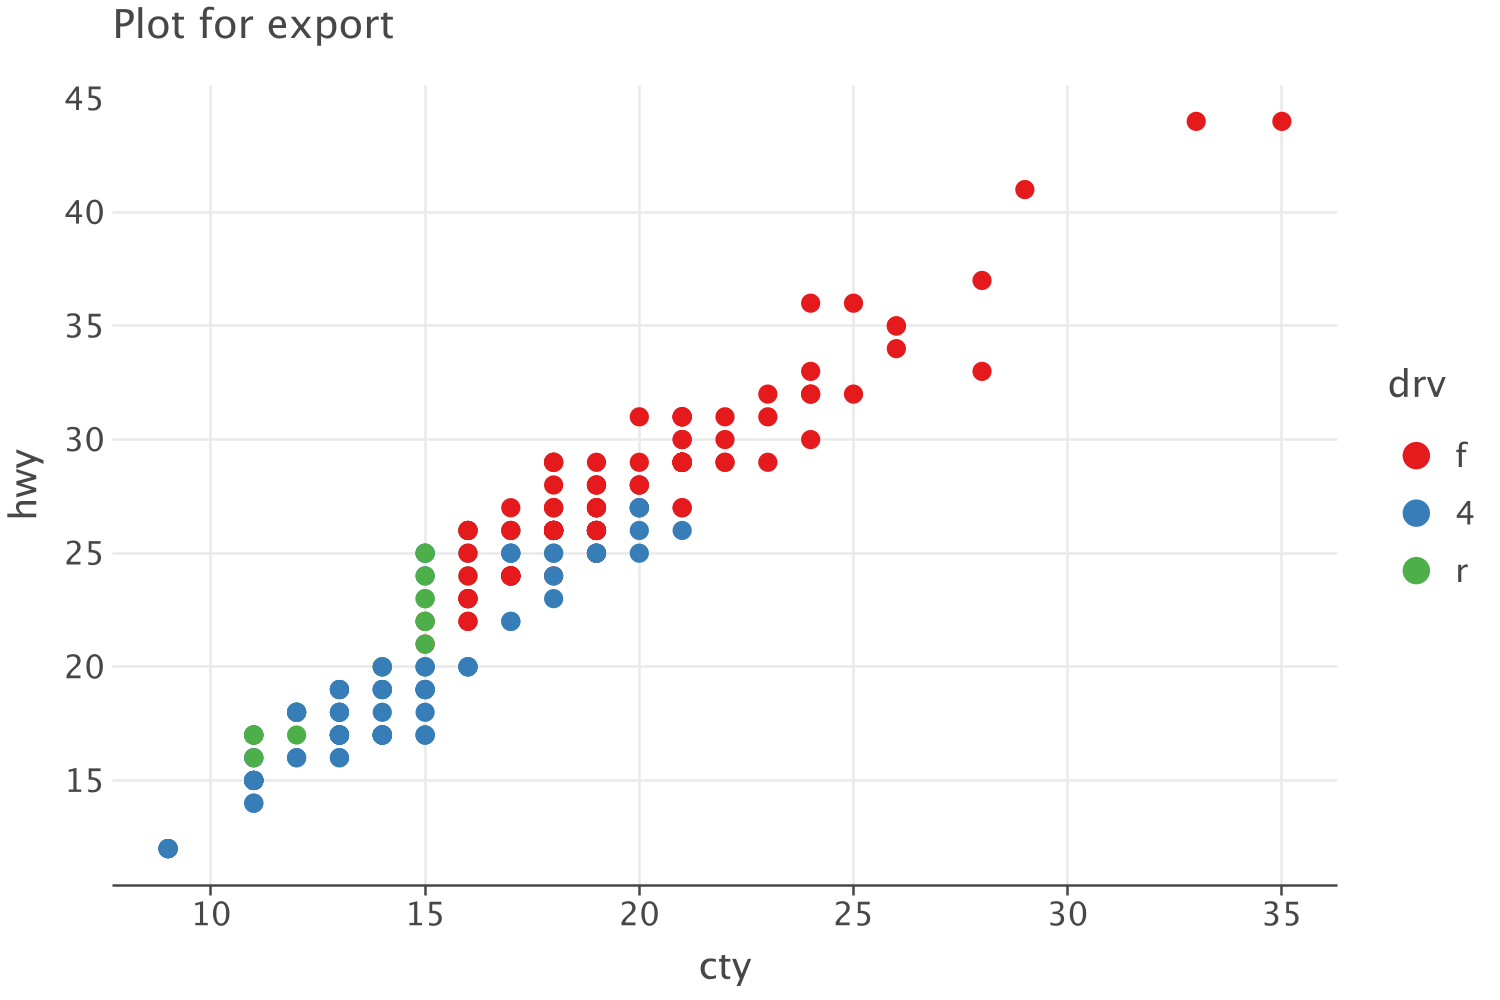

In [60]:
plotForExport.toBufferedImage(scale = 2.5, dpi = 9000)